In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1660 Ti (UUID: GPU-2a3d1dcb-c220-642c-91e9-cb51a54e9757)


In [2]:
dataset_file = "../datasets/london_merged.csv"

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
%matplotlib inline

In [5]:
dataset = pd.read_csv(dataset_file, index_col=['timestamp'], parse_dates=True)
dataset.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [6]:
dataset.columns

Index(['cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday',
       'is_weekend', 'season'],
      dtype='object')

In [7]:
dataset['hour'] = dataset.index.hour
dataset['day_of_the_week'] = dataset.index.dayofweek
dataset['day_of_month'] = dataset.index.day
dataset['month'] = dataset.index.month

In [8]:
dataset.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_the_week,day_of_month,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,6,4,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,6,4,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,6,4,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,6,4,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,6,4,1


<AxesSubplot:xlabel='timestamp', ylabel='cnt'>

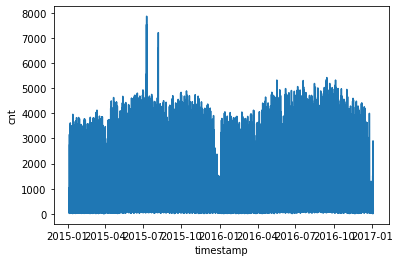

In [9]:
sns.lineplot(x=dataset.index, y='cnt', data=dataset)

In [10]:
train_size = int(len(dataset) * 0.8)

In [11]:
train_dataset = dataset.iloc[0:train_size]
test_dataset = dataset.iloc[train_size:]

In [12]:
train_dataset.shape

(13931, 13)

In [13]:
test_dataset.shape

(3483, 13)

In [14]:
from sklearn.preprocessing import RobustScaler

f_cols = ['t1', 't2', 'hum', 'wind_speed']

RS_scaler = RobustScaler()
Cnt_scaler = RobustScaler()

# RS_transformer = RS_scaler.fit(train_dataset[cols].to_numpy())
# Cnt_transformer = Cnt_scaler.fit(train_dataset[['cnt']])

train_dataset.loc[:,f_cols] = RS_scaler.fit_transform(train_dataset[f_cols].to_numpy())
train_dataset['cnt'] = Cnt_scaler.fit_transform(train_dataset[['cnt']])

test_dataset.loc[:,f_cols] = RS_scaler.fit_transform(test_dataset[f_cols].to_numpy())
test_dataset['cnt'] = Cnt_scaler.fit_transform(test_dataset[['cnt']])

C:\Users\Admin\AppData\Local\Temp/ipykernel_4388/388671367.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset.loc[:,f_cols] = RS_scaler.fit_transform(train_dataset[f_cols].to_numpy())
C:\Users\Admin\AppData\Local\Temp/ipykernel_4388/388671367.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset['cnt'] = Cnt_scaler.fit_transform(train_dataset[['cnt']])
C:\Users\Admin\AppData\Local\Temp/ipykernel_4388/388671367.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [15]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [16]:
time_steps = 10
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train_dataset, train_dataset.cnt, time_steps)
X_test, y_test = create_dataset(test_dataset, test_dataset.cnt, time_steps)
print(X_train.shape, y_train.shape)

(13921, 10, 13) (13921,)


In [17]:
X_train[0].shape

(10, 13)

In [18]:
model = tf.keras.Sequential()
model.add(
  tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(
      units=128,
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

In [19]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
392/392 [==============================] - 6s 10ms/step - loss: 0.3072 - mse: 0.3072 - val_loss: 0.0984 - val_mse: 0.0984
Epoch 2/30
392/392 [==============================] - 3s 8ms/step - loss: 0.0969 - mse: 0.0969 - val_loss: 0.0900 - val_mse: 0.0900
Epoch 3/30
392/392 [==============================] - 3s 8ms/step - loss: 0.0569 - mse: 0.0569 - val_loss: 0.0531 - val_mse: 0.0531
Epoch 4/30
392/392 [==============================] - 3s 8ms/step - loss: 0.0512 - mse: 0.0512 - val_loss: 0.0437 - val_mse: 0.0437
Epoch 5/30
392/392 [==============================] - 3s 8ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0434 - val_mse: 0.0434
Epoch 6/30
392/392 [==============================] - 3s 9ms/step - loss: 0.0341 - mse: 0.0341 - val_loss: 0.0473 - val_mse: 0.0473
Epoch 7/30
392/392 [==============================] - 3s 9ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0366 - val_mse: 0.0366
Epoch 8/30
392/392 [==============================] - 3s 9ms/step - loss: 0

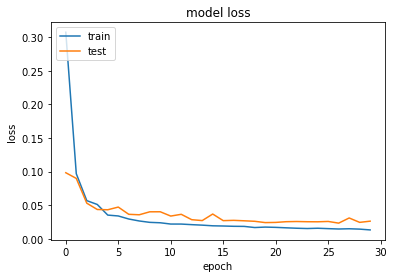

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
data = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

In [23]:
generator = TimeseriesGenerator(data, data, stride=1, length=4, batch_size=3)

In [24]:
generator[0]

(array([[1, 2, 3, 4],
        [2, 3, 4, 5],
        [3, 4, 5, 6]]),
 array([5, 6, 7]))

In [37]:
train_td_dataset = TimeseriesGenerator(train_dataset, train_dataset.cnt, stride=1, length=14, batch_size=32)
test_td_dataset = TimeseriesGenerator(test_dataset, test_dataset.cnt, stride=1, length=14, batch_size=32)

In [38]:
train_td_dataset[0][0].shape

(32, 14, 13)

In [39]:
model = tf.keras.Sequential()
model.add(
  tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(
      units=128,
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

In [40]:
history = model.fit(
    train_td_dataset,
    epochs=30,
    batch_size=32,
    validation_data = test_td_dataset
)

Epoch 1/30
435/435 [==============================] - 9s 15ms/step - loss: 0.2789 - mse: 0.2789 - val_loss: 0.1094 - val_mse: 0.1094
Epoch 2/30
435/435 [==============================] - 6s 14ms/step - loss: 0.0800 - mse: 0.0800 - val_loss: 0.0428 - val_mse: 0.0428
Epoch 3/30
435/435 [==============================] - 6s 14ms/step - loss: 0.0483 - mse: 0.0483 - val_loss: 0.0285 - val_mse: 0.0285
Epoch 4/30
435/435 [==============================] - 7s 15ms/step - loss: 0.0399 - mse: 0.0399 - val_loss: 0.0242 - val_mse: 0.0242
Epoch 5/30
435/435 [==============================] - 7s 15ms/step - loss: 0.0307 - mse: 0.0307 - val_loss: 0.0289 - val_mse: 0.0289
Epoch 6/30
435/435 [==============================] - 7s 16ms/step - loss: 0.0281 - mse: 0.0281 - val_loss: 0.0195 - val_mse: 0.0195
Epoch 7/30
435/435 [==============================] - 7s 15ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0188 - val_mse: 0.0188
Epoch 8/30
435/435 [==============================] - 6s 14ms/step - 

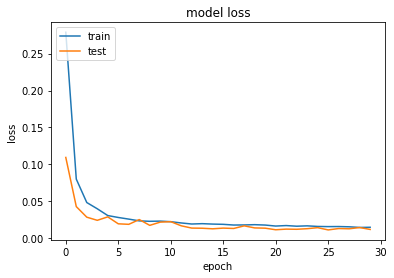

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()